<a href="https://colab.research.google.com/github/aborbala/tree-canopy/blob/main/Evaluation_DeepForest_and_Dalponte.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Comparative Evaluation of Tree Crown Detection Models: YOLO vs DeepForest vs Dalponte

Loads pre-trained YOLO, DeepForest, and Dalponte models, performs inference on test
imagery, evaluates predictions against ground truth using RandCrowns and confusion metrics,
and generates comprehensive performance comparisons.

Overview:
    Runs inference from three tree crown detection models (custom YOLO, DeepForest,
    Dalponte/Silva), converts predictions to georeferenced polygons, evaluates against
    high-quality ground truth annotations using RandCrowns metric and IoU-based metrics,
    and generates side-by-side visual and statistical comparisons.

Main Sections:

    1. Configuration - Set paths to models, imagery, ground truth, and evaluation parameters
    2. Helper Functions - Convert masks/boxes to polygons, classify predictions (TP/FP/FN)
    3. Overlap Removal - Filter highly overlapping predictions from same model
    4. RandCrowns Metric - Compute custom tree crown detection quality score
    5. Batch Evaluation - Process multiple tiles and aggregate metrics per model
    6. Confusion Matrix - Calculate TP, FP, FN across multiple IoU thresholds
    7. Performance Summary - Generate comparison table with F1-Score, Precision, Recall
    8. Prediction Export - Save model outputs as GeoPackage for further analysis
    9. Visual Comparison - Plot predictions from all models with ground truth overlay

Key Data:

    Input:
    - Satellite imagery (.tif format, RGB channels)
    - Ground truth annotations (GeoPackage with manually digitized tree crowns)
    - YOLO model weights (.pt file, custom-trained)
    - DeepForest pre-trained model (from deepforest package)
    - Dalponte/Silva segmentation results (GeoJSON format)
    
    Output:
    - Performance comparison DataFrame (F1-Score, Precision, Recall per model)
    - RandCrowns summary statistics (mean score per model/tile)
    - Confusion matrix components (TP, FP, FN per model)
    - Visualization plots (side-by-side model predictions)
    - Saved predictions (GeoPackage format for manual inspection)

Processing Parameters:

    - YOLO confidence threshold: 0.1
    - NMS threshold: 0.3
    - Overlap removal threshold: 0.8 (remove duplicates)
    - IoU thresholds for metrics: [0.25, 0.50, 0.75]
    - RandCrowns parameters: alpha=0.7, omega=1.2, gamma=3.0

Key Features:

    - Multi-model comparison on identical test tiles
    - RandCrowns metric for tree crown-specific evaluation
    - Confusion matrix computation across IoU thresholds
    - Overlap removal to eliminate duplicate detections
    - "Forgiving" classification allowing multiple predictions per GT
    - Spatial index acceleration for polygon intersection queries
    - GeoPackage export for manual quality control
    - World coordinate visualization with extent-based plotting
    - CRS fallback handling for missing projection information

Workflow:

    1. Load YOLO, DeepForest, and Dalponte models
    2. Configure ground truth and evaluation directories
    3. For each test tile:
       a. Run inference from all three models
       b. Convert masks/boxes to georeferenced polygons
       c. Remove highly overlapping predictions
       d. Load ground truth annotations
    4. Evaluate each model using:
       a. RandCrowns metric (mean score)
       b. Confusion metrics (TP, FP, FN) at 3 IoU thresholds
       c. F1-Score, Precision, Recall computation
    5. Export predictions to GeoPackage format
    6. Generate comparison table and visual plots
    7. Identify best-performing model across metrics

Comparison Outputs:

    - Mean RandCrowns per model
    - F1-Score @ IoU [0.25, 0.50, 0.75]
    - Precision @ IoU [0.25, 0.50, 0.75]
    - Recall @ IoU [0.25, 0.50, 0.75]
    - Confusion matrix (TP, FP, FN) per model
    - Side-by-side visual comparison on sample tiles
"""

In [ ]:
import os
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install deepforest
!pip install albumentations==1.3.1

In [ ]:
# Install all necessary libraries in one go
!pip install ultralytics geopandas rasterio pandas

import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio
from shapely.geometry import box
from ultralytics import YOLO
from deepforest import main as deepforest_main
import rasterio
import matplotlib.pyplot as plt

In [ ]:
AOI_CODE = "384_5816"
RASTER_DIR = f"/content/drive/MyDrive/masterthesis/data/{AOI_CODE}/sliced_imgs_2020S"
GROUND_TRUTH_DIR = f"/content/drive/MyDrive/masterthesis/data/{AOI_CODE}/evaluation_polygons/"
TILES_PATH = f"/content/drive/MyDrive/masterthesis/data/{AOI_CODE}/tiles.geojson"

DALPONTE_DIR = f"/content/drive/MyDrive/masterthesis/data/{AOI_CODE}/crowns_clean_no_structures_veg_mask"
SILVA_DIR = f"/content/drive/MyDrive/masterthesis/data/{AOI_CODE}/crowns_no_structures_veg_mask_Silva"

#YOLO_MODEL_PATH = "/content/drive/MyDrive/masterthesis/data/runs/no_struct_veg_mask_all_crowns_dice_loss/weights/last.pt"
#YOLO_MODEL_NAME = "All crowns, with dice loss" # A descriptive name for the summary table

YOLO_MODEL_PATH = "/content/drive/MyDrive/masterthesis/data/runs/no_struct_veg_mask_all_crowns_dice_loss_experiment_lr_0.0025_0.3_0.7/weights/best.pt"
YOLO_MODEL_NAME = "Only cadaster intersections, loss with don't care regio" # A descriptive name for the summary table

# --- Evaluation Parameters ---
IOU_THRESHOLDS = [0.25, 0.50, 0.75]
YOLO_CONFIDENCE_THRESHOLD = 0.1

NMS_THRESHOLD=0.3

OVERLAP_THRESHOLD=0.8

# --- Files to Process ---
# A sample of files to run the comparison on
SELECTED_FILES = [
    "3dm_33_384_5817_1_be_nobuild_149.tif",
    "3dm_33_384_5817_1_be_nobuild_85.tif",
    "3dm_33_384_5817_1_be_nobuild_59.tif",
    "3dm_33_385_5817_1_be_nobuild_122.tif",
    "3dm_33_385_5817_1_be_nobuild_22.tif",
    "3dm_33_384_5817_1_be_nobuild_62.tif",
    "3dm_33_384_5817_1_be_nobuild_21.tif",
    "3dm_33_384_5816_1_be_nobuild_84.tif",
    "3dm_33_384_5816_1_be_nobuild_2.tif",
    "3dm_33_384_5817_1_be_nobuild_40.tif"
]



In [ ]:
def masks_to_polygons(masks, original_bounds, out_shape, scores, min_area=1.0):
    """Converts YOLO masks to a GeoDataFrame of polygons."""
    # (This function is from your previous script and remains unchanged)
    from rasterio.transform import from_bounds
    from rasterio.features import shapes
    from shapely.geometry import shape as geom_shape
    import cv2

    polygons, properties = [], []
    transform = from_bounds(*original_bounds, width=out_shape[1], height=out_shape[0])
    for i, mask in enumerate(masks):
        mask_resized = cv2.resize(mask.astype(np.uint8), (out_shape[1], out_shape[0]), interpolation=cv2.INTER_NEAREST)
        for geom, val in shapes(mask_resized, mask=mask_resized, transform=transform):
            poly = geom_shape(geom)
            if poly.area > min_area:
                polygons.append(poly)
                properties.append({'confidence': float(scores[i])})
    return gpd.GeoDataFrame(properties, geometry=polygons)


def deepforest_boxes_to_polygons(df_boxes, image_path):
    """
    NEW FUNCTION: Converts DeepForest bounding boxes (in pixel coordinates)
    to a georeferenced GeoDataFrame of polygons.
    """
    if df_boxes is None or df_boxes.empty:
        return gpd.GeoDataFrame(geometry=[])

    with rasterio.open(image_path) as src:
        transform = src.transform
        crs = src.crs

    polygons, scores = [], []
    for _, row in df_boxes.iterrows():
        # Get pixel coordinates
        xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']

        # Convert corner pixels to world coordinates
        top_left_world = rasterio.transform.xy(transform, ymin, xmin)
        bottom_right_world = rasterio.transform.xy(transform, ymax, xmax)

        # Create a polygon from the world coordinates
        geom = box(top_left_world[0], bottom_right_world[1], bottom_right_world[0], top_left_world[1])
        polygons.append(geom)
        scores.append(row['score'])

    gdf = gpd.GeoDataFrame({'confidence': scores}, geometry=polygons, crs=crs)
    return gdf


def classify_predictions(preds_gdf, gts_gdf, iou_thresh=0.5):
    """
    Classifies predictions into TP, FP, and identifies FN.
    (This function is from your previous script and remains unchanged)
    """
    if preds_gdf.empty: return gpd.GeoDataFrame(), gpd.GeoDataFrame(), gts_gdf
    if gts_gdf.empty: return gpd.GeoDataFrame(), preds_gdf, gpd.GeoDataFrame()

    preds, gts = preds_gdf.copy(), gts_gdf.copy()
    matched_gt_indices = set()
    tp_indices, fp_indices = [], []

    for pred_idx, pred_row in preds.iterrows():
        best_iou, best_gt_idx = 0, -1
        for gt_idx, gt_row in gts.iterrows():
            if gt_idx in matched_gt_indices: continue
            iou = pred_row.geometry.intersection(gt_row.geometry).area / pred_row.geometry.union(gt_row.geometry).area
            if iou > best_iou: best_iou, best_gt_idx = iou, gt_idx
        if best_iou >= iou_thresh:
            tp_indices.append(pred_idx)
            matched_gt_indices.add(best_gt_idx)
        else:
            fp_indices.append(pred_idx)

    fn_indices = set(gts.index) - matched_gt_indices
    return preds.loc[tp_indices], preds.loc[fp_indices], gts.loc[list(fn_indices)]



In [ ]:
#FORGIVING
def classify_predictions(preds_gdf, gts_gdf, iou_thresh=0.5):
    """
    A "forgiving" version that allows multiple good predictions to match a single
    ground truth polygon, classifying them all as True Positives.
    """
    if gts_gdf.empty: return gpd.GeoDataFrame(), preds_gdf, gpd.GeoDataFrame()
    if preds_gdf.empty: return gpd.GeoDataFrame(), gpd.GeoDataFrame(), gts_gdf

    preds = preds_gdf.copy()
    gts = gts_gdf.copy()

    # Sort predictions by confidence score
    preds = preds.sort_values(by='confidence', ascending=False).reset_index(drop=True)

    preds['classification'] = 'FP'  # Start by assuming all are False Positives
    gts['matched'] = False

    # Standard greedy matching to find initial TPs and claim GTs
    for pred_idx, pred_row in preds.iterrows():
        best_iou, best_gt_idx = 0, -1
        for gt_idx, gt_row in gts[~gts['matched']].iterrows():
            iou = pred_row.geometry.intersection(gt_row.geometry).area / pred_row.geometry.union(gt_row.geometry).area
            if iou > best_iou:
                best_iou, best_gt_idx = iou, gt_idx

        if best_iou >= iou_thresh:
            preds.at[pred_idx, 'classification'] = 'TP'
            gts.at[best_gt_idx, 'matched'] = True

    # Re-evaluate the remaining FPs.
    # If an FP highly overlaps with ANY GT (even a matched one), reclassify it as a TP.
    for pred_idx, pred_row in preds[preds['classification'] == 'FP'].iterrows():
        for gt_idx, gt_row in gts.iterrows():
             iou = pred_row.geometry.intersection(gt_row.geometry).area / pred_row.geometry.union(gt_row.geometry).area
             if iou >= iou_thresh:
                 preds.at[pred_idx, 'classification'] = 'TP'
                 break # Move to the next FP

    tp_gdf = preds[preds['classification'] == 'TP']
    fp_gdf = preds[preds['classification'] == 'FP']
    fn_gdf = gts[~gts['matched']]

    return tp_gdf, fp_gdf, fn_gdf

In [ ]:
def remove_highly_overlapping_polygons(
    gdf: gpd.GeoDataFrame,
    overlap_threshold: float = 0.8
) -> gpd.GeoDataFrame:
    """
    Removes polygons that are highly overlapping with a higher-confidence polygon.

    This function iterates through polygons sorted by confidence. For any two
    polygons, if their intersection covers more than the `overlap_threshold`
    of the smaller polygon's area, the one with the lower confidence is removed.

    Args:
        gdf (gpd.GeoDataFrame): A GeoDataFrame of predictions, which should
                                have a 'geometry' and 'confidence' column.
        overlap_threshold (float): The threshold for suppression (e.g., 0.9 for 90%).

    Returns:
        gpd.GeoDataFrame: A new GeoDataFrame with highly overlapping duplicates removed.
    """
    if gdf.empty or len(gdf) < 2:
        return gdf

    # Ensure the gdf is sorted by confidence
    gdf_sorted = gdf.sort_values(by='confidence', ascending=False).reset_index(drop=True)

    # A boolean mask to mark polygons for removal. False means keep, True means remove.
    to_remove = pd.Series([False] * len(gdf_sorted), index=gdf_sorted.index)

    # Use a spatial index for much faster intersection queries
    sindex = gdf_sorted.sindex

    for i in range(len(gdf_sorted)):
        if to_remove[i]:
            continue

        current_poly = gdf_sorted.iloc[i].geometry

        # Find potential candidates for overlap using the spatial index
        possible_matches_index = list(sindex.intersection(current_poly.bounds))

        for j in possible_matches_index:
            # Don't compare a polygon to itself or to one already marked for removal
            # Also, only compare with polygons of lower confidence (j > i)
            if i >= j or to_remove[j]:
                continue

            candidate_poly = gdf_sorted.iloc[j].geometry

            # --- MODIFICATION START ---
            # Instead of a simple .contains(), calculate the overlap fraction.
            intersection_area = current_poly.intersection(candidate_poly).area

            # Since the list is sorted, the candidate_poly (j) will always be the
            # smaller or equal one in terms of confidence. We check its area.
            if candidate_poly.area > 0:
                overlap_fraction = intersection_area / candidate_poly.area

                if overlap_fraction > overlap_threshold:
                    to_remove[j] = True  # Mark the highly overlapping polygon for removal
            # --- MODIFICATION END ---

    # Return the GeoDataFrame keeping only the un-suppressed polygons
    gdf_clean = gdf_sorted[~to_remove].reset_index(drop=True)
    return gdf_clean

In [ ]:
def compute_randcrowns(pred_poly, target_poly, alpha=0.7, omega=1.2, gamma=3.0):
    from shapely.geometry import Polygon
    ra = target_poly.buffer(-alpha)
    ro = target_poly.buffer(omega)
    area_ra = ra.area
    area_rb = gamma * area_ra
    total_rb_area = area_rb + ro.area
    rb_radius_adjustment = ((total_rb_area / np.pi) ** 0.5) - ((ro.bounds[2] - ro.bounds[0]) / 2) if ro.area > 0 else 0
    rb = target_poly.buffer(omega + rb_radius_adjustment)
    a = pred_poly.intersection(ra).area
    b = rb.difference(pred_poly).area
    c = pred_poly.intersection(rb).area
    d = ra.difference(pred_poly).area
    denom = a + b + c + d
    return (a + b) / denom if denom > 0 else 0

def evaluate_randcrowns(preds, gts, iou_thresh=0.3):
    """Calculates the mean RandCrowns score for a set of predictions and ground truths."""
    if gts.empty or preds.empty: return 0.0
    scores = []
    preds_valid, gts_valid = preds.copy(), gts.copy()
    preds_valid['geometry'] = preds_valid.geometry.buffer(0)
    gts_valid['geometry'] = gts_valid.geometry.buffer(0)
    for _, gt_row in gts_valid.iterrows():
        best_score = 0
        for _, pred_row in preds_valid.iterrows():
            if pred_row.geometry.is_empty or gt_row.geometry.is_empty: continue
            iou = pred_row.geometry.intersection(gt_row.geometry).area / pred_row.geometry.union(gt_row.geometry).area
            if iou > iou_thresh:
                rc_score = compute_randcrowns(pred_row.geometry, gt_row.geometry)
                if rc_score > best_score:
                    best_score = rc_score
        scores.append(best_score)
    return np.mean(scores) if scores else 0


In [ ]:
print("--- Starting Comparative Evaluation ---")
yolo_model = YOLO(YOLO_MODEL_PATH)
df_model = deepforest_main.deepforest()
df_model.use_release()
tiles_gdf = gpd.read_file(TILES_PATH)
all_comparison_results = []

for tif_file in SELECTED_FILES:
    tile_name = tif_file.replace(".tif", "")
    raster_path = os.path.join(RASTER_DIR, tif_file)
    print(f"\n🔍 Processing Tile: {tile_name}")

    gt_path = os.path.join(GROUND_TRUTH_DIR, f"{tile_name}.gpkg")
    if not os.path.exists(gt_path): continue
    gdf_gt = gpd.read_file(gt_path)
    gdf_gt.geometry = gdf_gt.geometry.buffer(0)
    tile_row = tiles_gdf[tiles_gdf["tile_name"] == tile_name]
    if tile_row.empty: continue
    tile_geom = tile_row.geometry.values[0]
    gdf_gt = gpd.clip(gdf_gt, tile_geom)
    print(f"  ✅ Loaded {len(gdf_gt)} ground truth crowns.")

    yolo_results = yolo_model(raster_path, imgsz=640, conf=YOLO_CONFIDENCE_THRESHOLD, verbose=False, iou=NMS_THRESHOLD)
    if yolo_results[0].masks is None: gdf_yolo_pred = gpd.GeoDataFrame(geometry=[])
    else:
        with rasterio.open(raster_path) as src: bounds, shape = src.bounds, (src.height, src.width)
        masks, scores = yolo_results[0].masks.data.cpu().numpy(), yolo_results[0].boxes.conf.cpu().numpy()
        gdf_yolo_pred = masks_to_polygons(masks, bounds, shape, scores)
        if not gdf_yolo_pred.empty: gdf_yolo_pred.set_crs(tiles_gdf.crs, inplace=True)
    df_boxes = df_model.predict_image(path=raster_path, return_plot=False)
    gdf_df_pred = deepforest_boxes_to_polygons(df_boxes, raster_path)

    # Clean yolo predicitons:
    gdf_pred = remove_highly_overlapping_polygons(gdf_yolo_pred, OVERLAP_THRESHOLD)

    # DALPONTE
    dalponte_path = os.path.join(DALPONTE_DIR, f"{tile_name}.geojson")
    if not os.path.exists(dalponte_path):
        print(f"  ⚠️ Dalponte result not found for {tile_name}, skipping.")
        gdf_dalponte = gpd.GeoDataFrame(geometry=[])
    else:
        gdf_dalponte = gpd.read_file(dalponte_path)
        # Traditional methods don't have confidence scores, so we add a default for compatibility
        if not gdf_dalponte.empty:
            gdf_dalponte['confidence'] = 1.0

    gdf_dalponte_clean = gdf_dalponte.copy()
    if not gdf_dalponte_clean.empty:
        gdf_dalponte_clean.geometry = gdf_dalponte_clean.geometry.buffer(0)

    # SILVA
    silva_path = os.path.join(SILVA_DIR, f"{tile_name}.geojson")
    if not os.path.exists(silva_path):
        print(f"  ⚠️ silva result not found for {tile_name}, skipping.")
        gdf_silva = gpd.GeoDataFrame(geometry=[])
    else:
        gdf_silva = gpd.read_file(silva_path)
        # Traditional methods don't have confidence scores, so we add a default for compatibility
        if not gdf_silva.empty:
            gdf_silva['confidence'] = 1.0

    gdf_dalponte_clean = gdf_dalponte.copy()
    if not gdf_dalponte_clean.empty:
        gdf_dalponte_clean.geometry = gdf_dalponte_clean.geometry.buffer(0)

    # --- Evaluate Both Models ---
    models_to_evaluate = {YOLO_MODEL_NAME: gdf_yolo_pred, "DeepForest": gdf_df_pred, "Dalponte": gdf_dalponte_clean, "Silva": gdf_silva}
    for model_name, gdf_pred in models_to_evaluate.items():
        if not gdf_pred.empty: gdf_pred = gpd.clip(gdf_pred, tile_geom)
        print(f"  Evaluating {model_name}: Found {len(gdf_pred)} crowns.")

        # This dictionary will store all results for this model on this tile
        tile_results = {"model": model_name, "tile": tile_name}

        # Calculate RandCrowns
        tile_results["RandCrowns"] = evaluate_randcrowns(gdf_pred, gdf_gt)

        # Calculate TP, FP, FN for all IoU thresholds
        for thresh in IOU_THRESHOLDS:
            _, fp_gdf, fn_gdf = classify_predictions(gdf_pred, gdf_gt, iou_thresh=thresh)
            tp_count = len(gdf_gt) - len(fn_gdf)
            tile_results[f"TP_{thresh}"] = tp_count
            tile_results[f"FP_{thresh}"] = len(fp_gdf)
            tile_results[f"FN_{thresh}"] = len(fn_gdf)

        all_comparison_results.append(tile_results)

--- Starting Comparative Evaluation ---
Reading config file: /usr/local/lib/python3.12/dist-packages/deepforest/data/deepforest_config.yml


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Reading config file: /usr/local/lib/python3.12/dist-packages/deepforest/data/deepforest_config.yml


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs



🔍 Processing Tile: 3dm_33_384_5817_1_be_nobuild_149
  ✅ Loaded 14 ground truth crowns.
  Evaluating Only cadaster intersections, loss with don't care regio: Found 16 crowns.
  Evaluating DeepForest: Found 13 crowns.
  Evaluating Dalponte: Found 15 crowns.
  Evaluating Silva: Found 18 crowns.

🔍 Processing Tile: 3dm_33_384_5817_1_be_nobuild_85
  ✅ Loaded 56 ground truth crowns.
  Evaluating Only cadaster intersections, loss with don't care regio: Found 39 crowns.
  Evaluating DeepForest: Found 36 crowns.
  Evaluating Dalponte: Found 31 crowns.
  Evaluating Silva: Found 39 crowns.

🔍 Processing Tile: 3dm_33_384_5817_1_be_nobuild_59
  ✅ Loaded 38 ground truth crowns.
  Evaluating Only cadaster intersections, loss with don't care regio: Found 30 crowns.
  Evaluating DeepForest: Found 14 crowns.
  Evaluating Dalponte: Found 20 crowns.
  Evaluating Silva: Found 28 crowns.

🔍 Processing Tile: 3dm_33_385_5817_1_be_nobuild_122
  ✅ Loaded 22 ground truth crowns.
  Evaluating Only cadaster inter

In [ ]:
print("\n\n--- FINAL COMPARISON SUMMARY ---")
if not all_comparison_results:
    print("No results were generated to summarize.")
else:
    results_df = pd.DataFrame(all_comparison_results)

    summary_list = []

    print("\n--- Confusion Matrix Components ---")
    for model_name in results_df['model'].unique():
        model_df = results_df[results_df['model'] == model_name]
        for thresh in IOU_THRESHOLDS:
            total_tp = model_df[f"TP_{thresh}"].sum()
            total_fp = model_df[f"FP_{thresh}"].sum()
            total_fn = model_df[f"FN_{thresh}"].sum()

            print(f"\nModel: {model_name} @ IoU >= {thresh}")
            print(f"  - True Positives (TP):  {total_tp}")
            print(f"  - False Positives (FP): {total_fp}")
            print(f"  - False Negatives (FN): {total_fn}")
    print("-" * 40)

    # The rest of the script calculates the final summary table as before
    for model_name in results_df['model'].unique():
        model_df = results_df[results_df['model'] == model_name]

        avg_randcrowns = model_df["RandCrowns"].mean()
        model_summary = {"Model": model_name, "Mean RandCrowns": avg_randcrowns}

        for thresh in IOU_THRESHOLDS:
            total_tp = model_df[f"TP_{thresh}"].sum()
            total_fp = model_df[f"FP_{thresh}"].sum()
            total_fn = model_df[f"FN_{thresh}"].sum()

            precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
            recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
            f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

            model_summary[f"F1-Score @ {thresh}"] = f1_score
            model_summary[f"Precision @ {thresh}"] = precision
            model_summary[f"Recall @ {thresh}"] = recall

        summary_list.append(model_summary)

    # Display the final comparison table
    summary_df = pd.DataFrame(summary_list).set_index("Model")

    column_order = ["Mean RandCrowns"]
    for thresh in IOU_THRESHOLDS:
        column_order.extend([f"F1-Score @ {thresh}", f"Precision @ {thresh}", f"Recall @ {thresh}"])
    summary_df = summary_df[column_order]

    print("\nOverall Performance Comparison:")
    print(summary_df.to_string(float_format="%.3f"))



--- FINAL COMPARISON SUMMARY ---

--- Confusion Matrix Components ---

Model: Only cadaster intersections, loss with don't care regio @ IoU >= 0.25
  - True Positives (TP):  246
  - False Positives (FP): 49
  - False Negatives (FN): 57

Model: Only cadaster intersections, loss with don't care regio @ IoU >= 0.5
  - True Positives (TP):  195
  - False Positives (FP): 109
  - False Negatives (FN): 108

Model: Only cadaster intersections, loss with don't care regio @ IoU >= 0.75
  - True Positives (TP):  54
  - False Positives (FP): 250
  - False Negatives (FN): 249

Model: DeepForest @ IoU >= 0.25
  - True Positives (TP):  196
  - False Positives (FP): 40
  - False Negatives (FN): 107

Model: DeepForest @ IoU >= 0.5
  - True Positives (TP):  158
  - False Positives (FP): 79
  - False Negatives (FN): 145

Model: DeepForest @ IoU >= 0.75
  - True Positives (TP):  47
  - False Positives (FP): 190
  - False Negatives (FN): 256

Model: Dalponte @ IoU >= 0.25
  - True Positives (TP):  193
  

In [ ]:
def plot_model_comparison(image_path, gdf_gt, gdf_yolo, gdf_deepforest, gdf_dalponte, yolo_model_name, default_epsg="EPSG:25833"):
    """
    Generates a single plot visually comparing the outputs of both models against the ground truth.

    This version includes a fallback to a default EPSG code if an incoming GeoDataFrame
    is missing its CRS information.
    """
    with rasterio.open(image_path) as src:
        image_data = src.read([1, 2, 3])
        image_data = np.moveaxis(image_data, 0, -1)
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
        # The raster's CRS is the target CRS for plotting
        target_crs = default_epsg

    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(image_data, extent=extent)

    # Plot Ground Truth (thick, solid orange line)
    if not gdf_gt.empty:
        if gdf_gt.crs is None:
            gdf_gt = gdf_gt.set_crs(default_epsg)
        gdf_gt.to_crs(target_crs).boundary.plot(ax=ax, color='orange', linewidth=2.5, label='Ground Truth')

    # Plot Your Custom Model's Predictions (dashed cyan line)
    if not gdf_yolo.empty:
        if gdf_yolo.crs is None:
            gdf_yolo = gdf_yolo.set_crs(default_epsg)
        gdf_yolo.to_crs(target_crs).boundary.plot(ax=ax, color='cyan', linestyle='--', linewidth=2.0, label=f'{yolo_model_name}')

    # Plot DeepForest's Predictions (dotted magenta line)
    if not gdf_deepforest.empty:
        if gdf_deepforest.crs is None:
            gdf_deepforest = gdf_deepforest.set_crs(default_epsg)
        gdf_deepforest.to_crs(target_crs).boundary.plot(ax=ax, color='magenta', linestyle=':', linewidth=2.0, label='DeepForest')

    if not gdf_dalponte.empty:
        if gdf_dalponte.crs is None: gdf_dalponte = gdf_dalponte.set_crs(default_epsg)
        gdf_dalponte.to_crs(target_crs).boundary.plot(ax=ax, color='lime', linestyle='-.', linewidth=2.0, label='Dalponte')


    ax.set_title(f'Model Prediction Comparison on: {os.path.basename(image_path)}', fontsize=18)
    ax.set_xlabel('Easting (meters)', fontsize=12)
    ax.set_ylabel('Northing (meters)', fontsize=12)
    ax.legend(fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
print(raster_path)

/content/drive/MyDrive/masterthesis/data/384_5816/sliced_imgs_2020S/3dm_33_384_5817_1_be_nobuild_40.tif



Generating comparison plot...


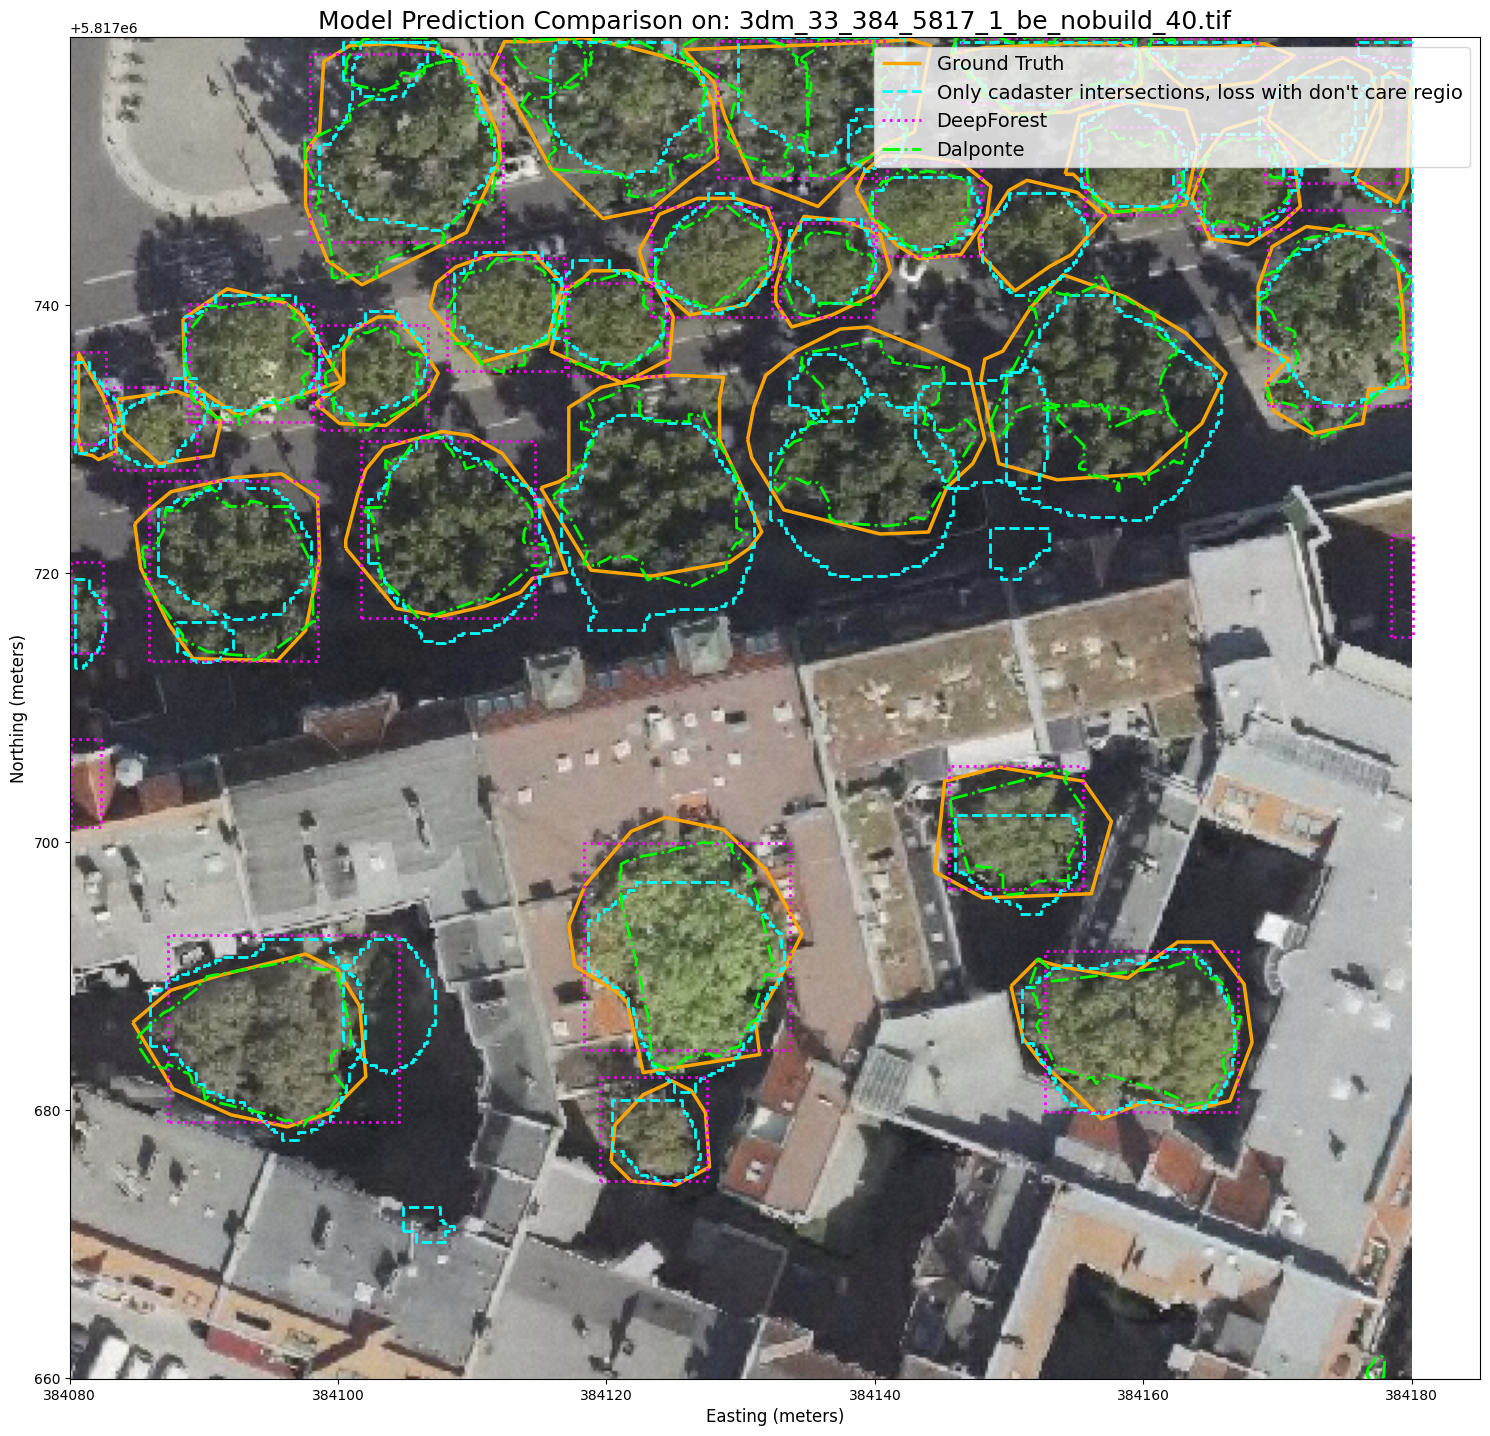

In [ ]:
print("\nGenerating comparison plot...")
plot_model_comparison(raster_path, gdf_gt, gdf_yolo_pred, gdf_df_pred, gdf_dalponte, YOLO_MODEL_NAME)


In [ ]:
print("--- Starting Full Processing and Saving Workflow ---")

PREDICTIONS_DIR = "/content/drive/MyDrive/masterthesis/data/processed_predictions"
os.makedirs(PREDICTIONS_DIR, exist_ok=True)

# Load models once
yolo_model = YOLO(YOLO_MODEL_PATH)
df_model = deepforest_main.deepforest()
df_model.use_release()
tiles_gdf = gpd.read_file(TILES_PATH)

for tif_file in SELECTED_FILES:
    tile_name = tif_file.replace(".tif", "")
    raster_path = os.path.join(RASTER_DIR, tif_file)
    print(f"\n🔍 Processing and Saving Predictions for Tile: {tile_name}")

    # --- Run/Load Predictions for all 3 Methods ---
    # 1. YOLOv11 Prediction
    yolo_results = yolo_model(raster_path, imgsz=640, conf=YOLO_CONFIDENCE_THRESHOLD, verbose=False, iou=NMS_THRESHOLD)
    if yolo_results[0].masks is None:
        gdf_yolo_raw = gpd.GeoDataFrame(geometry=[], crs="EPSG:25833")
    else:
        with rasterio.open(raster_path) as src: bounds, shape = src.bounds, (src.height, src.width)
        masks, scores = yolo_results[0].masks.data.cpu().numpy(), yolo_results[0].boxes.conf.cpu().numpy()
        gdf_yolo_raw = masks_to_polygons(masks, bounds, shape, scores)
        if not gdf_yolo_raw.empty: gdf_yolo_raw = gdf_yolo_raw.set_crs("EPSG:25833")

    # 2. DeepForest Prediction
    df_boxes = df_model.predict_image(path=raster_path, return_plot=False)
    gdf_df_raw = deepforest_boxes_to_polygons(df_boxes, raster_path)
    if 'confidence' not in gdf_df_raw.columns and not gdf_df_raw.empty:
        gdf_df_raw['confidence'] = 0.5 # Assign default confidence

    # 3. Load Dalponte Results
    dalponte_path = os.path.join(DALPONTE_DIR, f"{tile_name}.geojson")
    if not os.path.exists(dalponte_path):
        gdf_dalponte_raw = gpd.GeoDataFrame(geometry=[])
    else:
        gdf_dalponte_raw = gpd.read_file(dalponte_path)
        if not gdf_dalponte_raw.empty: gdf_dalponte_raw['confidence'] = 1.0

    # --- Post-Process and Save Each Method's Predictions ---

    # YOLO
    gdf_yolo_clean = remove_highly_overlapping_polygons(gdf_yolo_raw, OVERLAP_THRESHOLD)
    yolo_output_path = os.path.join(PREDICTIONS_DIR, f"{tile_name}_{YOLO_MODEL_NAME}.gpkg")
    gdf_yolo_clean.to_file(yolo_output_path, driver="GPKG")
    print(f"  ✅ Saved {len(gdf_yolo_clean)} cleaned YOLO predictions to file.")

    # DeepForest
    df_output_path = os.path.join(PREDICTIONS_DIR, f"{tile_name}_DeepForest.gpkg")
    gdf_df_raw.to_file(df_output_path, driver="GPKG")
    print(f"  ✅ Saved {len(gdf_df_raw)} cleaned DeepForest predictions to file.")

    # Dalponte
    gdf_dalponte_clean = gdf_dalponte_raw.copy()
    if not gdf_dalponte_clean.empty:
        gdf_dalponte_clean.geometry = gdf_dalponte_clean.geometry.buffer(0)
        # Ensure CRS is set before saving
        if gdf_dalponte_clean.crs is None: gdf_dalponte_clean = gdf_dalponte_clean.set_crs("EPSG:25833")
    dalponte_output_path = os.path.join(PREDICTIONS_DIR, f"{tile_name}_Dalponte.gpkg")
    gdf_dalponte_clean.to_file(dalponte_output_path, driver="GPKG")
    print(f"  ✅ Saved {len(gdf_dalponte_clean)} cleaned Dalponte predictions to file.")

print("\n\n--- All predictions processed and saved! ---")

--- Starting Full Processing and Saving Workflow ---
Reading config file: /usr/local/lib/python3.12/dist-packages/deepforest/data/deepforest_config.yml


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Reading config file: /usr/local/lib/python3.12/dist-packages/deepforest/data/deepforest_config.yml


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs



🔍 Processing and Saving Predictions for Tile: 3dm_33_384_5817_1_be_nobuild_149
  ✅ Saved 16 cleaned YOLO predictions to file.


  ✅ Saved 13 cleaned DeepForest predictions to file.
  ✅ Saved 15 cleaned Dalponte predictions to file.

🔍 Processing and Saving Predictions for Tile: 3dm_33_384_5817_1_be_nobuild_85
  ✅ Saved 37 cleaned YOLO predictions to file.
  ✅ Saved 36 cleaned DeepForest predictions to file.


  ✅ Saved 31 cleaned Dalponte predictions to file.

🔍 Processing and Saving Predictions for Tile: 3dm_33_384_5817_1_be_nobuild_59
  ✅ Saved 29 cleaned YOLO predictions to file.
  ✅ Saved 14 cleaned DeepForest predictions to file.


  ✅ Saved 20 cleaned Dalponte predictions to file.

🔍 Processing and Saving Predictions for Tile: 3dm_33_385_5817_1_be_nobuild_122
  ✅ Saved 22 cleaned YOLO predictions to file.


  ✅ Saved 21 cleaned DeepForest predictions to file.
  ✅ Saved 16 cleaned Dalponte predictions to file.

🔍 Processing and Saving Predictions for Tile: 3dm_33_385_5817_1_be_nobuild_22
  ✅ Saved 26 cleaned YOLO predictions to file.


  ✅ Saved 19 cleaned DeepForest predictions to file.
  ✅ Saved 15 cleaned Dalponte predictions to file.

🔍 Processing and Saving Predictions for Tile: 3dm_33_384_5817_1_be_nobuild_62
  ✅ Saved 38 cleaned YOLO predictions to file.
  ✅ Saved 27 cleaned DeepForest predictions to file.


  ✅ Saved 35 cleaned Dalponte predictions to file.

🔍 Processing and Saving Predictions for Tile: 3dm_33_384_5817_1_be_nobuild_21
  ✅ Saved 29 cleaned YOLO predictions to file.


  ✅ Saved 30 cleaned DeepForest predictions to file.
  ✅ Saved 24 cleaned Dalponte predictions to file.

🔍 Processing and Saving Predictions for Tile: 3dm_33_384_5816_1_be_nobuild_84
  ✅ Saved 20 cleaned YOLO predictions to file.


  ✅ Saved 14 cleaned DeepForest predictions to file.
  ✅ Saved 10 cleaned Dalponte predictions to file.

🔍 Processing and Saving Predictions for Tile: 3dm_33_384_5816_1_be_nobuild_2
  ✅ Saved 39 cleaned YOLO predictions to file.
  ✅ Saved 35 cleaned DeepForest predictions to file.


  ✅ Saved 38 cleaned Dalponte predictions to file.

🔍 Processing and Saving Predictions for Tile: 3dm_33_384_5817_1_be_nobuild_40
  ✅ Saved 39 cleaned YOLO predictions to file.
  ✅ Saved 28 cleaned DeepForest predictions to file.


  ✅ Saved 29 cleaned Dalponte predictions to file.


--- All predictions processed and saved! ---



🔍 Loading data for tile: 3dm_33_384_5817_1_be_nobuild_62


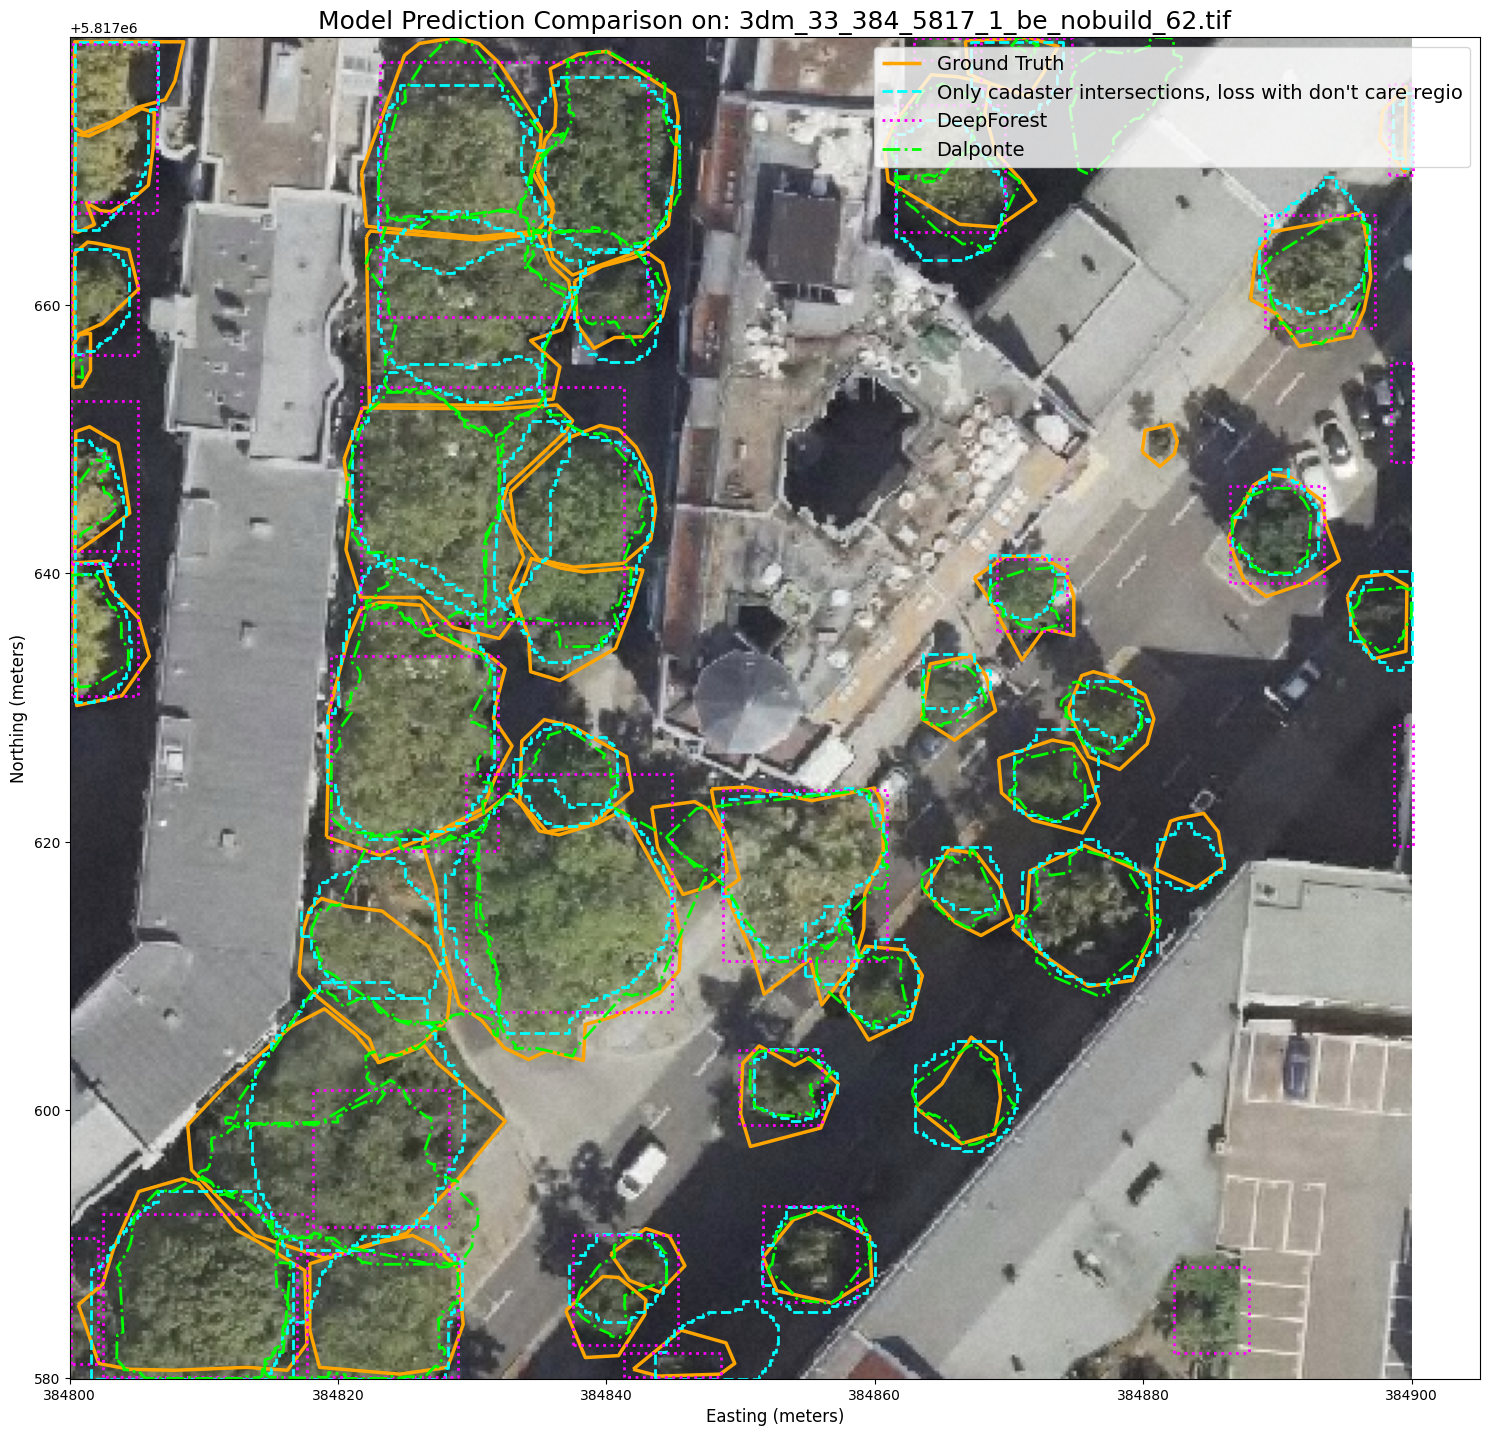


--- Metrics for Tile: 3dm_33_384_5817_1_be_nobuild_62 ---
                                                         F1-Score @ 0.5  Precision @ 0.5  Recall @ 0.5  TP  FP  FN
Model                                                                                                             
Only cadaster intersections, loss with don't care regio           0.741            0.789         0.698  30   8  13
DeepForest                                                        0.400            0.519         0.326  14  13  29
Dalponte                                                          0.538            0.600         0.488  21  14  22


In [ ]:
# Single predicition
tile_name_to_analyze = "3dm_33_384_5817_1_be_nobuild_62" # Example tile name

PREDICTIONS_DIR = "/content/drive/MyDrive/masterthesis/data/processed_predictions"

# --- Load all necessary data for the chosen tile ---
print(f"Loading data for tile: {tile_name_to_analyze}")
raster_path = os.path.join(RASTER_DIR, f"{tile_name_to_analyze}.tif")
gt_path = os.path.join(GROUND_TRUTH_DIR, f"{tile_name_to_analyze}.gpkg")

# Load Ground Truth
gdf_gt = gpd.read_file(gt_path)

# Load the pre-processed predictions from disk
gdf_yolo = gpd.read_file(os.path.join(PREDICTIONS_DIR, f"{tile_name_to_analyze}_{YOLO_MODEL_NAME}.gpkg"))
gdf_df = gpd.read_file(os.path.join(PREDICTIONS_DIR, f"{tile_name_to_analyze}_DeepForest.gpkg"))
gdf_dalponte = gpd.read_file(os.path.join(PREDICTIONS_DIR, f"{tile_name_to_analyze}_Dalponte.gpkg"))

plot_model_comparison(
    raster_path,
    gdf_gt,
    gdf_yolo,
    gdf_df,
    gdf_dalponte,
    YOLO_MODEL_NAME
)

models_to_evaluate = {
    YOLO_MODEL_NAME: gdf_yolo,
    "DeepForest": gdf_df,
    "Dalponte": gdf_dalponte
}

tile_metrics = []
for model_name, gdf_pred in models_to_evaluate.items():
    tp_gdf, fp_gdf, fn_gdf = classify_predictions(gdf_pred, gdf_gt, iou_thresh=0.5)
    precision = len(tp_gdf) / (len(tp_gdf) + len(fp_gdf)) if (len(tp_gdf) + len(fp_gdf)) > 0 else 0
    recall = len(tp_gdf) / (len(tp_gdf) + len(fn_gdf)) if (len(tp_gdf) + len(fn_gdf)) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    tile_metrics.append({
        "Model": model_name,
        "F1-Score @ 0.5": f1_score,
        "Precision @ 0.5": precision,
        "Recall @ 0.5": recall,
        "TP": len(tp_gdf),
        "FP": len(fp_gdf),
        "FN": len(fn_gdf)
    })

print(f"\n--- Metrics for Tile: {tile_name_to_analyze} ---")
summary_df = pd.DataFrame(tile_metrics).set_index("Model")
print(summary_df.to_string(float_format="%.3f"))